In [1]:
import torch
import torch.nn as nn
import numpy as np

class Net(nn.Module):
    def __init__(self, xz_dim, layers):
        super(Net, self).__init__()
        self.xz_dim = xz_dim
        
        modules = [nn.Linear(xz_dim, layers[0]), nn.ReLU()]
        
        prev_layer = layers[0]
        for layer in layers[1:]:
            modules.append(nn.Linear(prev_layer,layer))
            modules.append(nn.ReLU())
            prev_layer = layer
        
        modules.append(nn.Linear(prev_layer, 1))
        self.linears = nn.Sequential(*modules)
           
    def forward(self, xz, z):

        h = self.linears(xz)
        x = xz[:,0].unsqueeze(1)
        xz_2 = torch.cat((x,z),1)
        h2 = self.linears(xz_2)
        return h, h2
    


In [33]:

n = 2000

corrs = np.linspace(-0.99, 0.99, 20)
theos = []
mines = []
for j,corr in enumerate(corrs):
    theo = -0.5 * np.log(1 - np.square(corr))
    cov = np.array([[1,corr],[corr,1]])
    xz = np.random.multivariate_normal(mean = [0,0], cov = cov, size = n)
    z = np.random.normal(0, scale = 1, size = n)[:,None]
    layers = [32,16]
    net = Net(xz.shape[-1], layers)

    epochs = 50
    batch_size = 256
    display_step = epochs // 2

    opt = torch.optim.Adam(net.parameters(), lr = 1e-3)
    for epoch in range(epochs+1):

        loss_mu = 0

        for i in range(n // batch_size):
            opt.zero_grad()

            xz_b = torch.from_numpy(xz[i * batch_size : (i+1) * batch_size]).float()
            z_b = xz_b[torch.randperm(len(xz_b)),1].unsqueeze(1)

            h_i,z_i = net(xz_b, z_b)


            loss = -torch.mean(h_i)+torch.log(torch.mean(torch.exp(z_i)))
            loss.backward()
            opt.step()
            loss_mu += loss
        loss_mu /= (n//batch_size)
        #if epoch % display_step == 0:
            #print("MI: {0:.3f}".format(-loss_mu))
            #print("Actual: {0:.3f}".format(theo))
            
    theos.append((corr, theo))
    mines.append((corr, -loss_mu))
    print("{}/{}".format(j+1,len(corrs)))
    print("MI: {0:.3f} - Actual: {1:.3f}".format(-loss_mu, theo))
    #print("Actual: {0:.3f}".format(theo))
theos = np.array(theos)
mines = np.array(mines)

1/20
MI: 1.632 - Actual: 1.959
2/20
MI: 0.725 - Actual: 0.768
3/20
MI: 0.447 - Actual: 0.472
4/20
MI: 0.299 - Actual: 0.307
5/20
MI: 0.170 - Actual: 0.199
6/20
MI: 0.116 - Actual: 0.124
7/20
MI: 0.056 - Actual: 0.071
8/20
MI: 0.029 - Actual: 0.035
9/20
MI: 0.005 - Actual: 0.012
10/20
MI: 0.006 - Actual: 0.001
11/20
MI: 0.005 - Actual: 0.001
12/20
MI: 0.001 - Actual: 0.012
13/20
MI: 0.047 - Actual: 0.035
14/20
MI: 0.095 - Actual: 0.071
15/20
MI: 0.136 - Actual: 0.124
16/20
MI: 0.177 - Actual: 0.199
17/20
MI: 0.342 - Actual: 0.307
18/20
MI: 0.485 - Actual: 0.472
19/20
MI: 0.700 - Actual: 0.768
20/20
MI: 1.635 - Actual: 1.959


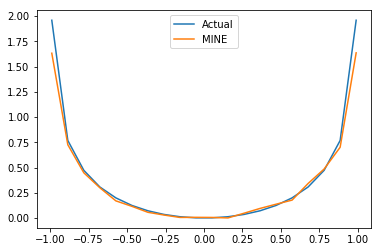

In [35]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(theos[:,0],theos[:,1], label = 'Actual')
plt.plot(mines[:,0], mines[:,1], label = 'MINE')
plt.legend()